# 1. Install Dependencies and Setup

In [4]:
!pip install tensorflow-macos tensorflow-metal opencv-python matplotlib

In [5]:
!pip list

Package                 Version
----------------------- ---------
absl-py                 1.4.0
appnope                 0.1.3
asttokens               2.2.1
astunparse              1.6.3
backcall                0.2.0
cachetools              5.3.0
certifi                 2022.12.7
charset-normalizer      3.1.0
comm                    0.1.3
contourpy               1.0.7
cycler                  0.11.0
debugpy                 1.6.7
decorator               5.1.1
executing               1.2.0
flatbuffers             23.3.3
fonttools               4.39.3
gast                    0.4.0
google-auth             2.17.3
google-auth-oauthlib    1.0.0
google-pasta            0.2.0
grpcio                  1.53.0
h5py                    3.8.0
idna                    3.4
ipykernel               6.22.0
ipython                 8.12.0
jax                     0.4.8
jedi                    0.18.2
jupyter_client          8.2.0
jupyter_core            5.3.0
keras                   2.12.0
kiwisolver             

In [6]:
import tensorflow as tf
import os

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [9]:
import cv2
import imghdr

In [10]:
data_dir = 'data' 

In [11]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [12]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [13]:
import numpy as np
from matplotlib import pyplot as plt

In [14]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.
Metal device set to: Apple M1 Pro


In [15]:
data_iterator = data.as_numpy_iterator()

In [16]:
batch = data_iterator.next()

2023-04-17 15:12:17.775085: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


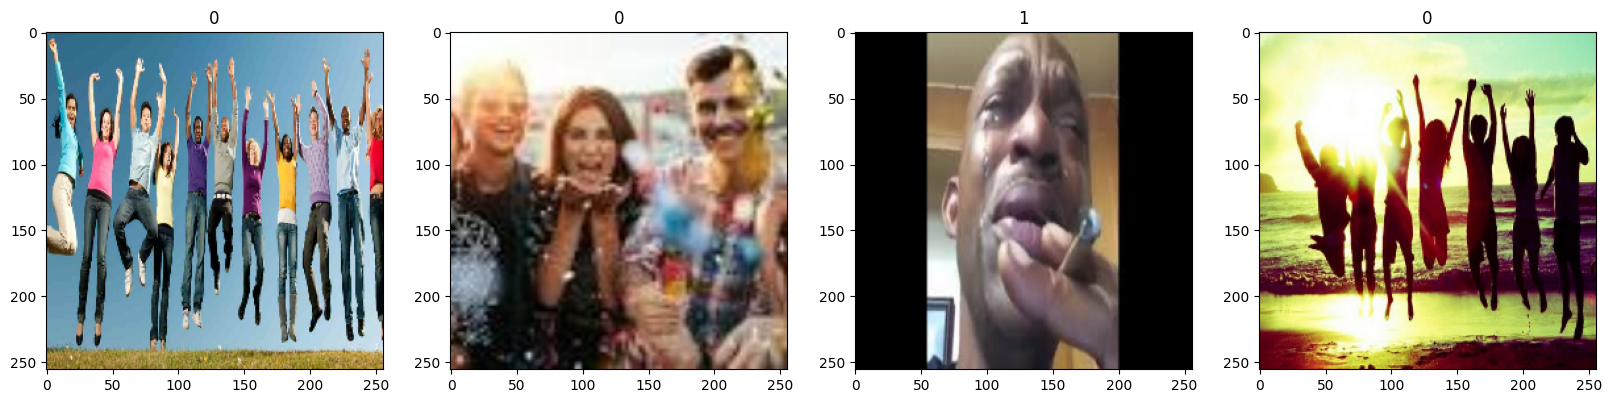

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [18]:
data = data.map(lambda x,y: (x/255, y))

In [19]:
data.as_numpy_iterator().next()

(array([[[[0.01568628, 0.01568628, 0.01568628],
          [0.01568628, 0.01568628, 0.01568628],
          [0.01568628, 0.01568628, 0.01568628],
          ...,
          [0.01176471, 0.01176471, 0.01176471],
          [0.01176471, 0.01176471, 0.01176471],
          [0.01568628, 0.01568628, 0.01568628]],
 
         [[0.01568628, 0.01568628, 0.01568628],
          [0.01568628, 0.01568628, 0.01568628],
          [0.01568628, 0.01568628, 0.01568628],
          ...,
          [0.01176471, 0.01176471, 0.01176471],
          [0.01176471, 0.01176471, 0.01176471],
          [0.01568628, 0.01568628, 0.01568628]],
 
         [[0.01568628, 0.01568628, 0.01568628],
          [0.01568628, 0.01568628, 0.01568628],
          [0.01568628, 0.01568628, 0.01568628],
          ...,
          [0.01176471, 0.01176471, 0.01176471],
          [0.01176471, 0.01176471, 0.01176471],
          [0.01568628, 0.01568628, 0.01568628]],
 
         ...,
 
         [[0.01960784, 0.01960784, 0.01960784],
          [0.01960

# 5. Split Data

In [20]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [21]:
train_size

7

In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [23]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [25]:
model = Sequential()

In [26]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [29]:
logdir='logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 4s 300ms/step - loss: 0.7145 - accuracy: 0.5268 - val_loss: 0.6780 - val_accuracy: 0.4688
Epoch 2/20
7/7 [==============================] - 3s 290ms/step - loss: 0.6061 - accuracy: 0.7143 - val_loss: 0.5347 - val_accuracy: 0.8281
Epoch 3/20
7/7 [==============================] - 3s 304ms/step - loss: 0.5583 - accuracy: 0.7634 - val_loss: 0.4002 - val_accuracy: 0.8438
Epoch 4/20
7/7 [==============================] - 3s 314ms/step - loss: 0.3746 - accuracy: 0.8661 - val_loss: 0.3175 - val_accuracy: 0.9062
Epoch 5/20
7/7 [==============================] - 3s 288ms/step - loss: 0.3394 - accuracy: 0.8750 - val_loss: 0.3330 - val_accuracy: 0.8750
Epoch 6/20
7/7 [==============================] - 3s 299ms/step - loss: 0.2555 - accuracy: 0.9196 - val_loss: 0.3318 - val_accuracy: 0.8594
Epoch 7/20
7/7 [==============================] - 3s 304ms/step - loss: 0.2703 - accuracy: 0.8750 - val_loss: 0.2390 - val_accuracy: 0.9062
Epoch 8/20
7/7 [====

# 8. Plot Performance

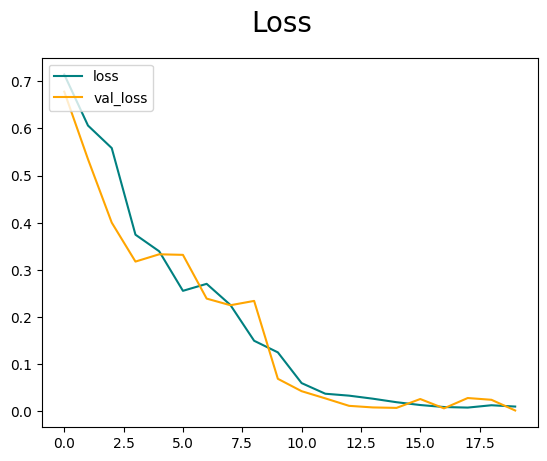

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

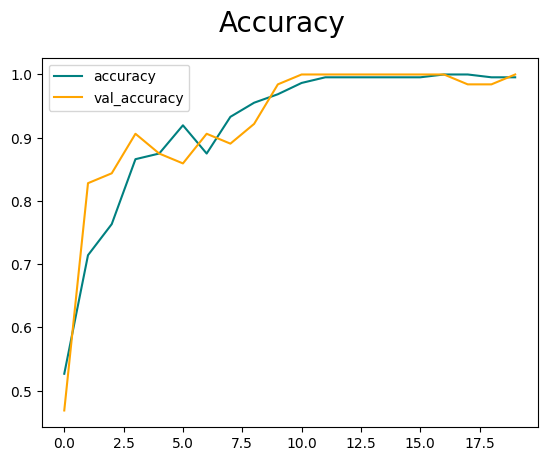

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [34]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [35]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [36]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 91ms/step


In [37]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [38]:
import cv2

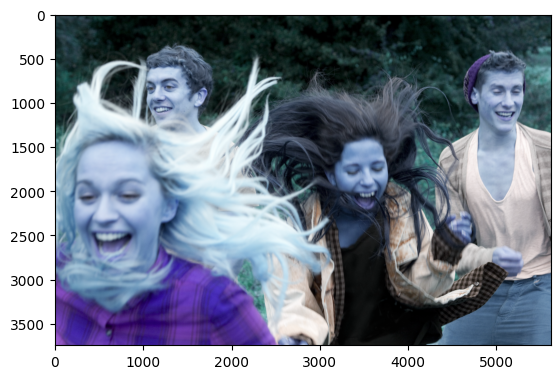

In [59]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

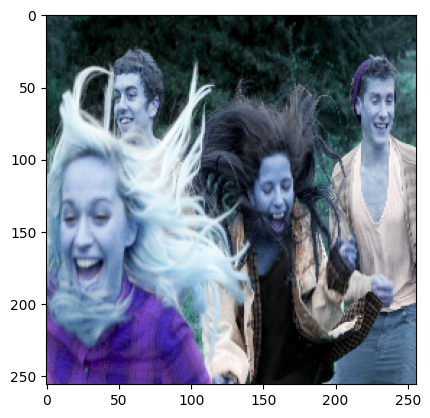

In [60]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [61]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 21ms/step


In [62]:
yhat

array([[0.41392782]], dtype=float32)

In [63]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('./models/imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 67ms/step


array([[0.41392782]], dtype=float32)